source: https://www.kaggle.com/datasets/tigganeha4/diabetes-dataset-2019

In [1]:
!pip install keras-tuner


In [2]:
# Import necessary  libraries

# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import keras_tuner as kt

%matplotlib inline

# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [3]:
!pip install -q kaggle
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
kaggle_token_path = '/content/drive/My Drive/kaggle.json'
kaggle_dir = '/root/.kaggle/'

# Check if kaggle directory exists, if not, create it
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Copy kaggle.json from Google Drive to appropriate directory
if os.path.exists(kaggle_token_path):
    shutil.copy(kaggle_token_path, kaggle_dir)
    os.chmod(kaggle_dir + 'kaggle.json', 600)

# Download dataset from Kaggle
!kaggle datasets download -d tigganeha4/diabetes-dataset-2019

# Unzip the dataset
!unzip -o diabetes-dataset-2019.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
diabetes-dataset-2019.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  diabetes-dataset-2019.zip
  inflating: diabetes_dataset__2019.csv  


In [4]:
# Initialize Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Kaggle_Dataset") \
    .getOrCreate()

# Load dataset into Spark DataFrame
df = spark.read.csv("diabetes_dataset__2019.csv", header=True, inferSchema=True)
df.show()

+------------+------+---------------+------+--------------------+---+-------+-------+-----+----------+---------------+------------+----------+-------+----------+---------+------------+--------+
|         Age|Gender|Family_Diabetes|highBP|    PhysicallyActive|BMI|Smoking|Alcohol|Sleep|SoundSleep|RegularMedicine|    JunkFood|    Stress|BPLevel|Pregancies|Pdiabetes|UriationFreq|Diabetic|
+------------+------+---------------+------+--------------------+---+-------+-------+-----+----------+---------------+------------+----------+-------+----------+---------+------------+--------+
|       50-59|  Male|             no|   yes|      one hr or more| 39|     no|     no|    8|       6.0|             no|occasionally| sometimes|   high|         0|        0|    not much|      no|
|       50-59|  Male|             no|   yes|less than half an hr| 28|     no|     no|    8|       6.0|            yes|  very often| sometimes| normal|         0|        0|    not much|      no|
|       40-49|  Male|         

In [5]:
# Show schema to confirm date type
df.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Family_Diabetes: string (nullable = true)
 |-- highBP: string (nullable = true)
 |-- PhysicallyActive: string (nullable = true)
 |-- BMI: integer (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- Alcohol: string (nullable = true)
 |-- Sleep: integer (nullable = true)
 |-- SoundSleep: double (nullable = true)
 |-- RegularMedicine: string (nullable = true)
 |-- JunkFood: string (nullable = true)
 |-- Stress: string (nullable = true)
 |-- BPLevel: string (nullable = true)
 |-- Pregancies: integer (nullable = true)
 |-- Pdiabetes: string (nullable = true)
 |-- UriationFreq: string (nullable = true)
 |-- Diabetic: string (nullable = true)



In [6]:
# Convert PySpark DataFrame to Pandas DataFrame
df = df.toPandas()

# Remove leading and trailing spaces from all column names
df.columns = df.columns.str.strip()

# Set the option to display all columns
pd.options.display.max_columns = None

# Show the first few rows of the DataFrame
df.head()


,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6.0,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6.0,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6.0,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8.0,no,occasionally,sometimes,normal,0.0,0,not much,no


# Data Preprocessing

In [7]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Age                  0
Gender               0
Family_Diabetes      0
highBP               0
PhysicallyActive     0
BMI                  4
Smoking              0
Alcohol              0
Sleep                0
SoundSleep           0
RegularMedicine      0
JunkFood             0
Stress               0
BPLevel              0
Pregancies          42
Pdiabetes            1
UriationFreq         0
Diabetic             1
dtype: int64


In [8]:
# Drop rows with missing values
df.dropna(inplace=True)
df.isnull().sum()

Age                 0
Gender              0
Family_Diabetes     0
highBP              0
PhysicallyActive    0
BMI                 0
Smoking             0
Alcohol             0
Sleep               0
SoundSleep          0
RegularMedicine     0
JunkFood            0
Stress              0
BPLevel             0
Pregancies          0
Pdiabetes           0
UriationFreq        0
Diabetic            0
dtype: int64

In [9]:
df.dtypes

Age                  object
Gender               object
Family_Diabetes      object
highBP               object
PhysicallyActive     object
BMI                 float64
Smoking              object
Alcohol              object
Sleep                 int32
SoundSleep          float64
RegularMedicine      object
JunkFood             object
Stress               object
BPLevel              object
Pregancies          float64
Pdiabetes            object
UriationFreq         object
Diabetic             object
dtype: object

In [10]:
# Display summary statistics of numerical columns
df.describe().round()

,BMI,Sleep,SoundSleep,Pregancies
count,905.0,905.0,905.0,905.0
mean,26.0,7.0,6.0,0.0
std,5.0,1.0,2.0,1.0
min,15.0,4.0,0.0,0.0
25%,22.0,6.0,4.0,0.0
50%,24.0,7.0,6.0,0.0
75%,28.0,8.0,7.0,0.0
max,45.0,11.0,11.0,4.0


# Compute the correlation matrix on the entire DataFrame

<ipython-input-11-80fa3bdeea4a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


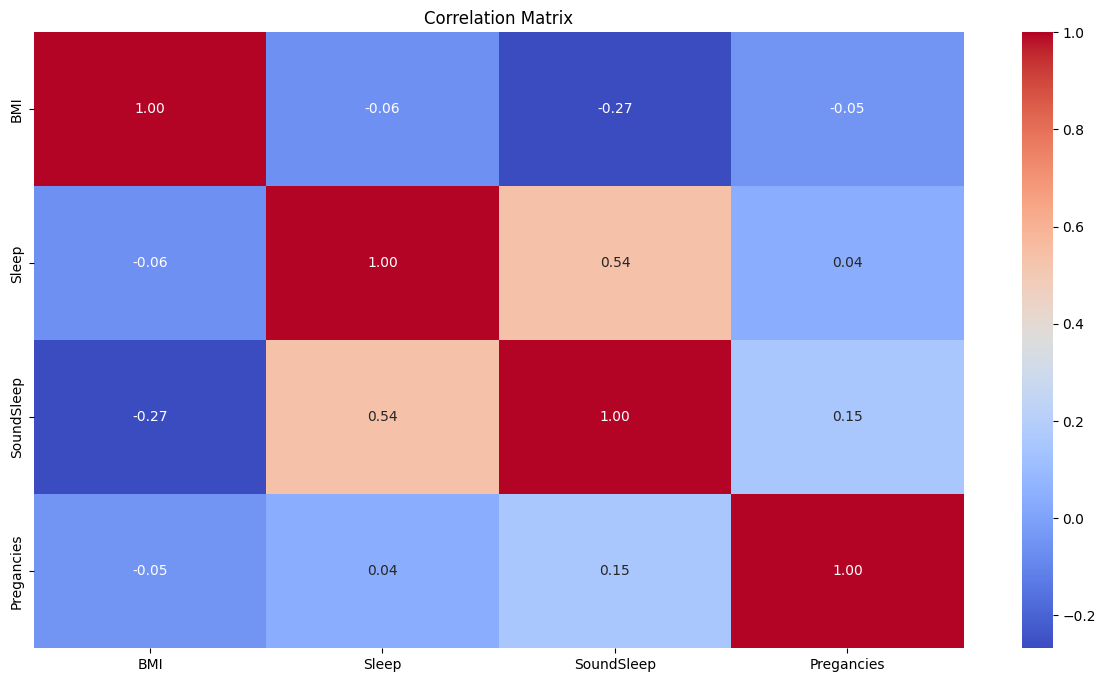

In [11]:
# Compute the correlation matrix on the entire DataFrame
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# For binary categorical variables, convert 'yes' to 1 and 'no' to 0

In [12]:
# For binary categorical variables, convert 'yes' to 1 and 'no' to 0

binary_cols = ['Family_Diabetes', 'highBP', 'Smoking', 'Alcohol', 'RegularMedicine', 'Diabetic']
for col in binary_cols:
    df[col] = df[col].map({'no': 0, 'yes': 1})
df['Pdiabetes'] = df['Pdiabetes'].map({'0': 0, 'yes': 1})

In [13]:
df.head()

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,0,1,one hr or more,39.0,0,0,8,6.0,0.0,occasionally,sometimes,high,0.0,0,not much,0.0
1,50-59,Male,0,1,less than half an hr,28.0,0,0,8,6.0,1.0,very often,sometimes,normal,0.0,0,not much,0.0
2,40-49,Male,0,0,one hr or more,24.0,0,0,6,6.0,0.0,occasionally,sometimes,normal,0.0,0,not much,0.0
3,50-59,Male,0,0,one hr or more,23.0,0,0,8,6.0,0.0,occasionally,sometimes,normal,0.0,0,not much,0.0
4,40-49,Male,0,0,less than half an hr,27.0,0,0,8,8.0,0.0,occasionally,sometimes,normal,0.0,0,not much,0.0


In [14]:
df.dtypes

Age                  object
Gender               object
Family_Diabetes       int64
highBP                int64
PhysicallyActive     object
BMI                 float64
Smoking               int64
Alcohol               int64
Sleep                 int32
SoundSleep          float64
RegularMedicine     float64
JunkFood             object
Stress               object
BPLevel              object
Pregancies          float64
Pdiabetes             int64
UriationFreq         object
Diabetic            float64
dtype: object

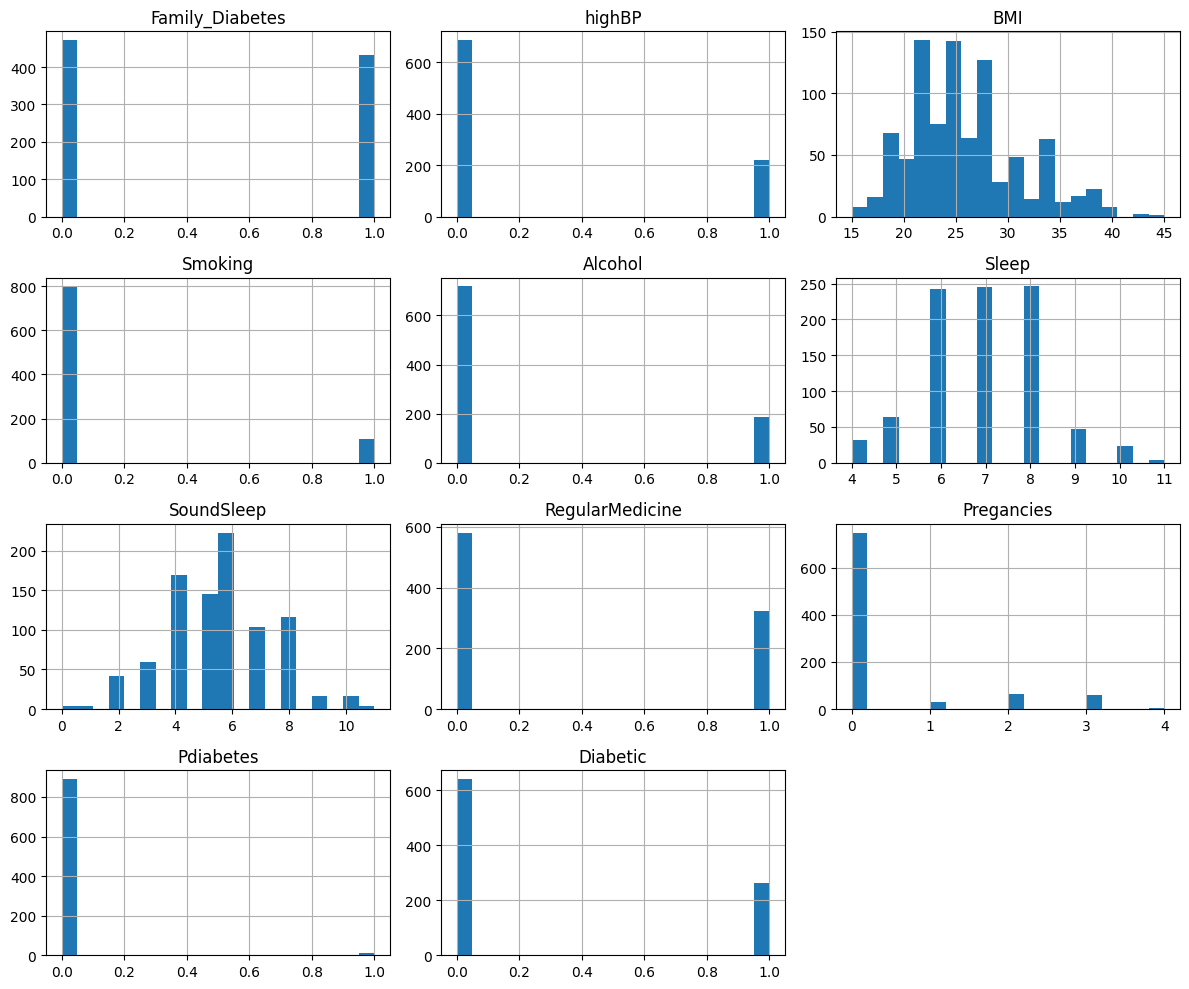

In [15]:
# Explore distributions of numerical variables using histograms
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

In [16]:
# Convert categorical variables to numerical representation using one-hot encoding
df = pd.get_dummies(df, columns=['Age', 'Gender', 'PhysicallyActive', 'JunkFood', 'Stress', 'BPLevel', 'UriationFreq'])

In [17]:
df.head()

,Family_Diabetes,highBP,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,Pregancies,Pdiabetes,Diabetic,Age_40-49,Age_50-59,Age_60 or older,Age_less than 40,Gender_Female,Gender_Male,PhysicallyActive_less than half an hr,PhysicallyActive_more than half an hr,PhysicallyActive_none,PhysicallyActive_one hr or more,JunkFood_always,JunkFood_occasionally,JunkFood_often,JunkFood_very often,Stress_always,Stress_not at all,Stress_sometimes,Stress_very often,BPLevel_High,BPLevel_Low,BPLevel_high,BPLevel_low,BPLevel_normal,BPLevel_normal,UriationFreq_not much,UriationFreq_quite often
0,0,1,39.0,0,0,8,6.0,0.0,0.0,0,0.0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,0,1,28.0,0,0,8,6.0,1.0,0.0,0,0.0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,0,0,24.0,0,0,6,6.0,0.0,0.0,0,0.0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0
3,0,0,23.0,0,0,8,6.0,0.0,0.0,0,0.0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,0,0,27.0,0,0,8,8.0,0.0,0.0,0,0.0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0


In [18]:
df.dtypes

Family_Diabetes                            int64
highBP                                     int64
BMI                                      float64
Smoking                                    int64
Alcohol                                    int64
Sleep                                      int32
SoundSleep                               float64
RegularMedicine                          float64
Pregancies                               float64
Pdiabetes                                  int64
Diabetic                                 float64
Age_40-49                                  uint8
Age_50-59                                  uint8
Age_60 or older                            uint8
Age_less than 40                           uint8
Gender_Female                              uint8
Gender_Male                                uint8
PhysicallyActive_less than half an hr      uint8
PhysicallyActive_more than half an hr      uint8
PhysicallyActive_none                      uint8
PhysicallyActive_one

#Preprocessing steps: consolidating categorical columns

In [19]:
# Combine age columns into one "age" column
age_columns = ['Age_40-49', 'Age_50-59', 'Age_60 or older', 'Age_less than 40']
age_conditions = [
    (df['Age_40-49'] == 1),
    (df['Age_50-59'] == 1),
    (df['Age_60 or older'] == 1),
    (df['Age_less than 40'] == 1)
]
age_values = ['40-49', '50-59', '60 or older', 'less than 40']
df['age'] = np.select(age_conditions, age_values, default='Unknown')
df.drop(age_columns, axis=1, inplace=True)


In [20]:
# Combine gender columns into one "gender" column
gender_columns = ['Gender_Female', 'Gender_Male']
gender_conditions = [
    (df['Gender_Female'] == 1),
    (df['Gender_Male'] == 1)
]
gender_values = ['Female', 'Male']
df['gender'] = np.select(gender_conditions, gender_values, default='Unknown')
df.drop(gender_columns, axis=1, inplace=True)


In [21]:
# Combine PhysicallyActive columns into one "physicallyactive" column
physically_active_columns = ['PhysicallyActive_less than half an hr',
                             'PhysicallyActive_more than half an hr',
                             'PhysicallyActive_none',
                             'PhysicallyActive_one hr or more']
physically_active_conditions = [
    (df['PhysicallyActive_less than half an hr'] == 1),
    (df['PhysicallyActive_more than half an hr'] == 1),
    (df['PhysicallyActive_none'] == 1),
    (df['PhysicallyActive_one hr or more'] == 1)
]
physically_active_values = ['Less than half an hr', 'More than half an hr', 'None', 'One hr or more']
df['physicallyactive'] = np.select(physically_active_conditions, physically_active_values, default='Unknown')
df.drop(physically_active_columns, axis=1, inplace=True)


In [22]:
# Combine JunkFood columns into one "junkfood" column
junkfood_columns = ['JunkFood_always', 'JunkFood_occasionally', 'JunkFood_often', 'JunkFood_very often']
junkfood_conditions = [
    (df['JunkFood_always'] == 1),
    (df['JunkFood_occasionally'] == 1),
    (df['JunkFood_often'] == 1),
    (df['JunkFood_very often'] == 1)
]
junkfood_values = ['Always', 'Occasionally', 'Often', 'Very often']
df['junkfood'] = np.select(junkfood_conditions, junkfood_values, default='Unknown')
df.drop(junkfood_columns, axis=1, inplace=True)


In [23]:
# Combine Stress columns into one "stress" column
stress_columns = ['Stress_always', 'Stress_not at all', 'Stress_sometimes', 'Stress_very often']
stress_conditions = [
    (df['Stress_always'] == 1),
    (df['Stress_not at all'] == 1),
    (df['Stress_sometimes'] == 1),
    (df['Stress_very often'] == 1)
]
stress_values = ['Always', 'Not at all', 'Sometimes', 'Very often']
df['stress'] = np.select(stress_conditions, stress_values, default='Unknown')
df.drop(stress_columns, axis=1, inplace=True)


In [24]:
# Combine BPLevel columns into one "bplevel" column
bplevel_columns = ['BPLevel_High', 'BPLevel_Low', 'BPLevel_high', 'BPLevel_low', 'BPLevel_normal']
bplevel_conditions = [
    (df['BPLevel_High'] == 1),
    (df['BPLevel_Low'] == 1),
    (df['BPLevel_high'] == 1),
    (df['BPLevel_low'] == 1),
    (df['BPLevel_normal '] == 1)
]
bplevel_values = ['High', 'Low', 'High', 'Low', 'Normal']
df['bplevel'] = np.select(bplevel_conditions, bplevel_values, default='Unknown')

# Drop individual BPLevel columns and BPLevel_normal column
columns_to_drop = [column.strip() for column in bplevel_columns]  # Remove leading/trailing spaces
df.drop(columns=columns_to_drop, inplace=True)


In [25]:
# Combine UrinationFreq columns into one "urinationfreq" column
urinationfreq_columns = ['UriationFreq_not much', 'UriationFreq_quite often']
urinationfreq_conditions = [
    (df['UriationFreq_not much'] == 1),
    (df['UriationFreq_quite often'] == 1)
]
urinationfreq_values = ['Not much', 'Quite often']
df['urinationfreq'] = np.select(urinationfreq_conditions, urinationfreq_values, default='Unknown')
df.drop(urinationfreq_columns, axis=1, inplace=True)


In [26]:
# Display the updated DataFrame
df

,Family_Diabetes,highBP,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,Pregancies,Pdiabetes,Diabetic,BPLevel_normal,age,gender,physicallyactive,junkfood,stress,bplevel,urinationfreq
0,0,1,39.0,0,0,8,6.0,0.0,0.0,0,0.0,0,50-59,Male,One hr or more,Occasionally,Sometimes,High,Not much
1,0,1,28.0,0,0,8,6.0,1.0,0.0,0,0.0,0,50-59,Male,Less than half an hr,Very often,Sometimes,Unknown,Not much
2,0,0,24.0,0,0,6,6.0,0.0,0.0,0,0.0,0,40-49,Male,One hr or more,Occasionally,Sometimes,Unknown,Not much
3,0,0,23.0,0,0,8,6.0,0.0,0.0,0,0.0,0,50-59,Male,One hr or more,Occasionally,Sometimes,Unknown,Not much
4,0,0,27.0,0,0,8,8.0,0.0,0.0,0,0.0,0,40-49,Male,Less than half an hr,Occasionally,Sometimes,Unknown,Not much
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,1,0,25.0,0,0,8,6.0,0.0,0.0,0,1.0,0,less than 40,Male,More than half an hr,Often,Sometimes,Unknown,Not much
948,1,1,27.0,0,0,6,5.0,1.0,0.0,0,1.0,0,60 or older,Male,More than half an hr,Occasionally,Sometimes,High,Quite often
949,0,1,23.0,0,0,6,5.0,1.0,0.0,0,0.0,0,60 or older,Male,None,Occasionally,Sometimes,High,Not much
950,0,1,27.0,0,1,6,5.0,1.0,0.0,0,0.0,0,60 or older,Male,Less than half an hr,Occasionally,Very often,High,Not much


In [27]:
# Drop the 'BPLevel_normal' column from df
df.drop(columns=['BPLevel_normal ', 'junkfood'], inplace=True)

# Print the first few rows of the DataFrame to confirm that the column has been dropped
df.head()


,Family_Diabetes,highBP,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,Pregancies,Pdiabetes,Diabetic,age,gender,physicallyactive,stress,bplevel,urinationfreq
0,0,1,39.0,0,0,8,6.0,0.0,0.0,0,0.0,50-59,Male,One hr or more,Sometimes,High,Not much
1,0,1,28.0,0,0,8,6.0,1.0,0.0,0,0.0,50-59,Male,Less than half an hr,Sometimes,Unknown,Not much
2,0,0,24.0,0,0,6,6.0,0.0,0.0,0,0.0,40-49,Male,One hr or more,Sometimes,Unknown,Not much
3,0,0,23.0,0,0,8,6.0,0.0,0.0,0,0.0,50-59,Male,One hr or more,Sometimes,Unknown,Not much
4,0,0,27.0,0,0,8,8.0,0.0,0.0,0,0.0,40-49,Male,Less than half an hr,Sometimes,Unknown,Not much


In [28]:
print(df.columns)

Index(['Family_Diabetes', 'highBP', 'BMI', 'Smoking', 'Alcohol', 'Sleep',
       'SoundSleep', 'RegularMedicine', 'Pregancies', 'Pdiabetes', 'Diabetic',
       'age', 'gender', 'physicallyactive', 'stress', 'bplevel',
       'urinationfreq'],
      dtype='object')


In [29]:
# Make a copy of the DataFrame to avoid altering the original DataFrame
df_encoded = df.copy()

# Convert 'age' column into binary format
df_encoded['age'] = df_encoded['age'].apply(lambda x: 1 if x != 'less than 40' else 0)

# Convert 'gender' column into binary format
df_encoded['gender'] = df_encoded['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Convert 'physicallyactive' column into binary format
df_encoded['physicallyactive'] = df_encoded['physicallyactive'].apply(lambda x: 1 if x != 'None' else 0)

# Convert 'stress' column into binary format
df_encoded['stress'] = df_encoded['stress'].apply(lambda x: 1 if x != 'Not at all' else 0)

# Convert 'bplevel' column into binary format
df_encoded['bplevel'] = df_encoded['bplevel'].apply(lambda x: 1 if x == 'High' else 0)

# Convert 'urinationfreq' column into binary format
df_encoded['urinationfreq'] = df_encoded['urinationfreq'].apply(lambda x: 1 if x == 'Quite often' else 0)

# Assuming df is your DataFrame
df_encoded.rename(columns={col: col.lower() for col in df.columns}, inplace=True)

# Show the updated DataFrame
df_encoded.head()


,family_diabetes,highbp,bmi,smoking,alcohol,sleep,soundsleep,regularmedicine,pregancies,pdiabetes,diabetic,age,gender,physicallyactive,stress,bplevel,urinationfreq
0,0,1,39.0,0,0,8,6.0,0.0,0.0,0,0.0,1,1,1,1,1,0
1,0,1,28.0,0,0,8,6.0,1.0,0.0,0,0.0,1,1,1,1,0,0
2,0,0,24.0,0,0,6,6.0,0.0,0.0,0,0.0,1,1,1,1,0,0
3,0,0,23.0,0,0,8,6.0,0.0,0.0,0,0.0,1,1,1,1,0,0
4,0,0,27.0,0,0,8,8.0,0.0,0.0,0,0.0,1,1,1,1,0,0


In [30]:
# Drop rows with missing values
df_encoded.dropna(inplace=True)
# Check for missing values
print("\nMissing values:")
print(df_encoded.isnull().sum())


Missing values:
family_diabetes     0
highbp              0
bmi                 0
smoking             0
alcohol             0
sleep               0
soundsleep          0
regularmedicine     0
pregancies          0
pdiabetes           0
diabetic            0
age                 0
gender              0
physicallyactive    0
stress              0
bplevel             0
urinationfreq       0
dtype: int64


In [31]:
df_encoded.dtypes

family_diabetes       int64
highbp                int64
bmi                 float64
smoking               int64
alcohol               int64
sleep                 int32
soundsleep          float64
regularmedicine     float64
pregancies          float64
pdiabetes             int64
diabetic            float64
age                   int64
gender                int64
physicallyactive      int64
stress                int64
bplevel               int64
urinationfreq         int64
dtype: object

In [32]:
df_encoded.to_csv('processed.csv' )

# Target and Feature Variables

In [33]:
# Split the data into features (X) and target variable (y)
X = df_encoded.drop('diabetic', axis=1)
# Define target vector
y = df_encoded["diabetic"].values.reshape(-1, 1)
y = y.ravel()

In [34]:
# Display the processed DataFrame
print("\nProcessed DataFrame:")
X.head()


Processed DataFrame:


,family_diabetes,highbp,bmi,smoking,alcohol,sleep,soundsleep,regularmedicine,pregancies,pdiabetes,age,gender,physicallyactive,stress,bplevel,urinationfreq
0,0,1,39.0,0,0,8,6.0,0.0,0.0,0,1,1,1,1,1,0
1,0,1,28.0,0,0,8,6.0,1.0,0.0,0,1,1,1,1,0,0
2,0,0,24.0,0,0,6,6.0,0.0,0.0,0,1,1,1,1,0,0
3,0,0,23.0,0,0,8,6.0,0.0,0.0,0,1,1,1,1,0,0
4,0,0,27.0,0,0,8,8.0,0.0,0.0,0,1,1,1,1,0,0


In [35]:
print("\nTarget variable:")
y[:5]


Target variable:


array([0., 0., 0., 0., 0.])

## Training and testing of datasets

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


## Logistic Regression

In [37]:
# Creating the logistic regression instance
model = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [38]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [39]:
# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,104,15
Diabetes Present,19,43


-------------------------------------------
Accuracy Score : 0.8121546961325967
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.85      0.87      0.86       119
Diabetes Present       0.74      0.69      0.72        62

        accuracy                           0.81       181
       macro avg       0.79      0.78      0.79       181
    weighted avg       0.81      0.81      0.81       181



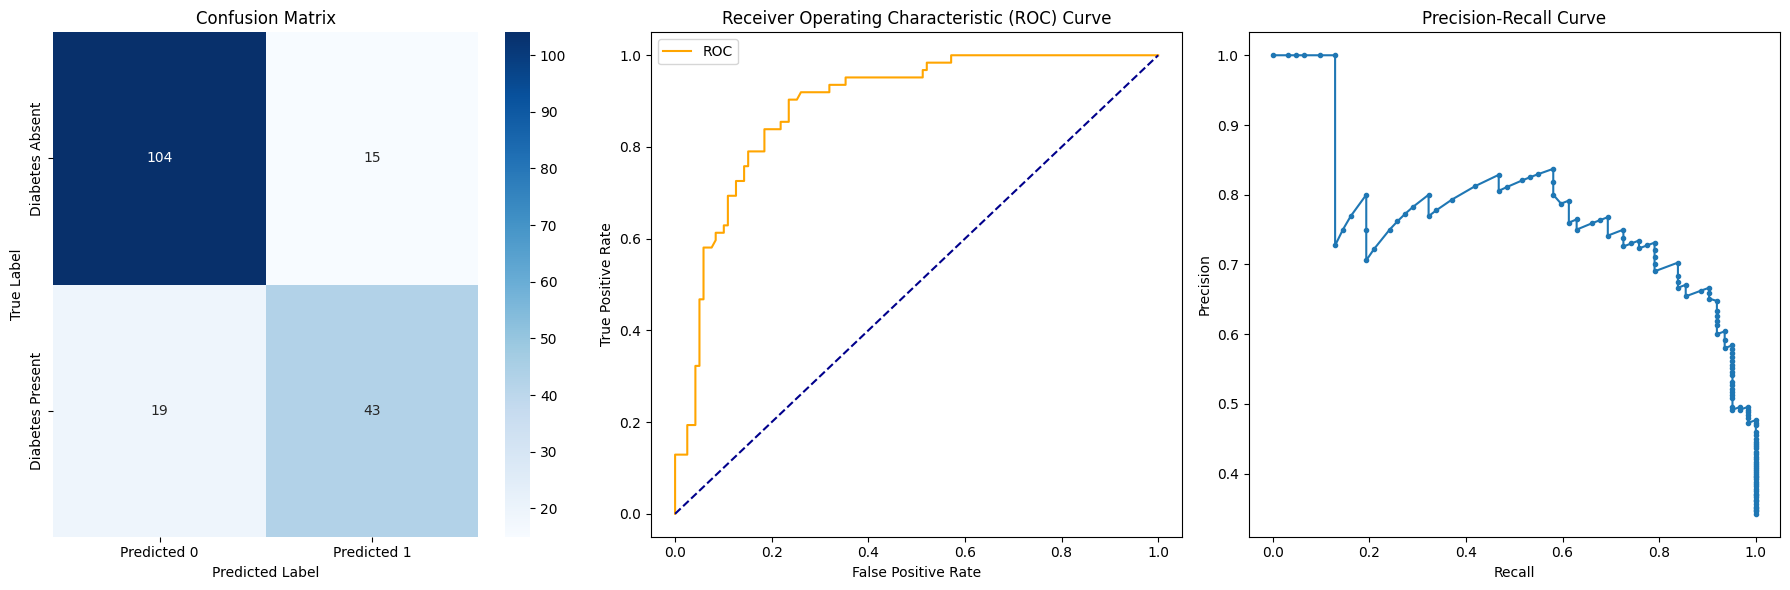

In [40]:
# Making predictions and calculating probabilities using the testing data
predictions = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of the positive class

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


## Random Forest Model

In [41]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Calculating the confusion matrix
predictions = rf_model.predict(X_test_scaled)

In [42]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [43]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix


,Predicted 0,Predicted 1
Diabetes Absent,117,2
Diabetes Present,5,57


Accuracy Score : 0.9613259668508287
Classification Report
                  precision    recall  f1-score   support

 Diabetes Absent       0.96      0.98      0.97       119
Diabetes Present       0.97      0.92      0.94        62

        accuracy                           0.96       181
       macro avg       0.96      0.95      0.96       181
    weighted avg       0.96      0.96      0.96       181



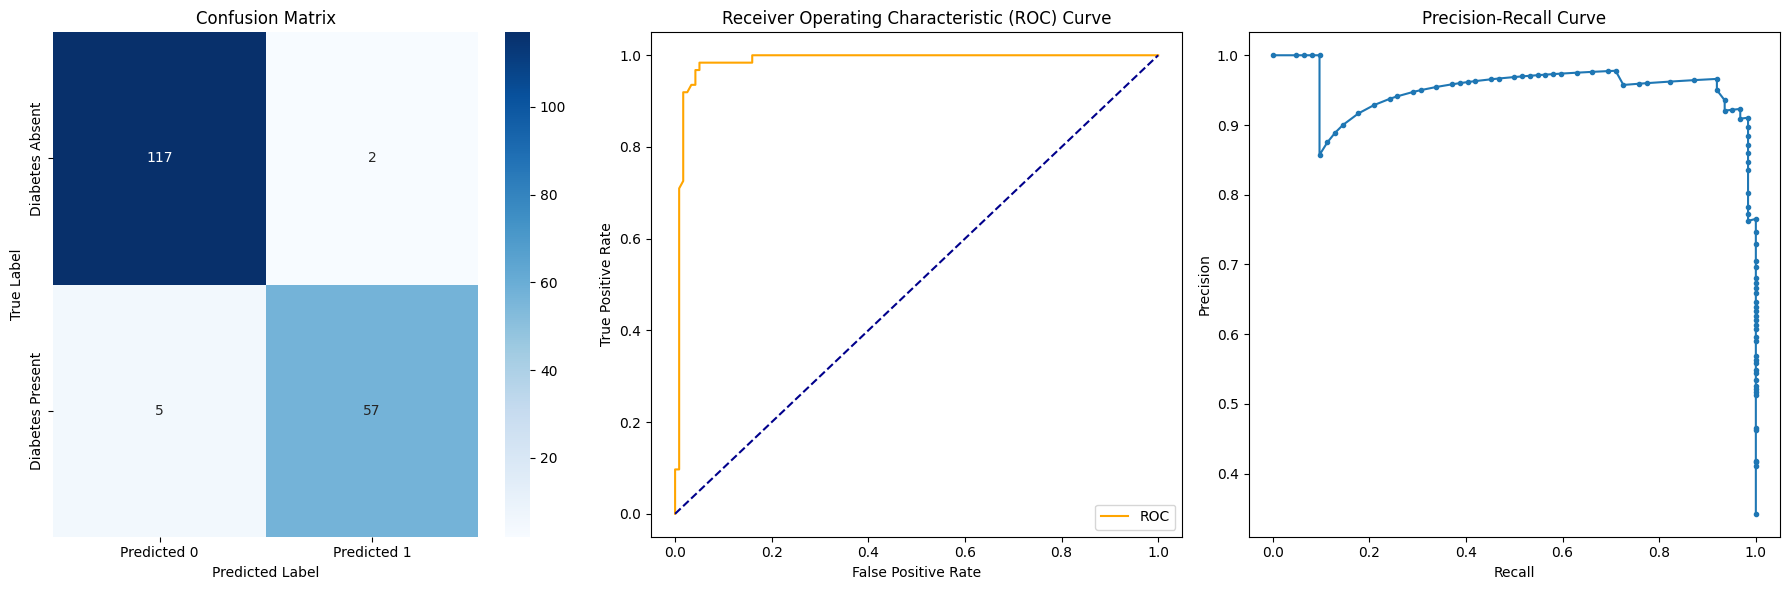

In [44]:
# Making predictions and calculating probabilities using the testing data
predictions = rf_model.predict(X_test_scaled)
probs = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of the positive class

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


# Feature Importance

In [45]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.25023878796993904, 'regularmedicine'),
 (0.13217836794890808, 'age'),
 (0.12937625475979014, 'bmi'),
 (0.08827005304150079, 'soundsleep'),
 (0.06796555739661064, 'bplevel'),
 (0.06513610066223852, 'sleep'),
 (0.04842016077038489, 'family_diabetes'),
 (0.041046969271303684, 'highbp'),
 (0.04074955333344878, 'pregancies'),
 (0.024505639500458185, 'urinationfreq'),
 (0.022525872105938847, 'physicallyactive'),
 (0.0223222444219014, 'alcohol'),
 (0.02114513560337464, 'stress'),
 (0.01766774229628826, 'gender'),
 (0.016803739951259326, 'pdiabetes'),
 (0.011647820966654659, 'smoking')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

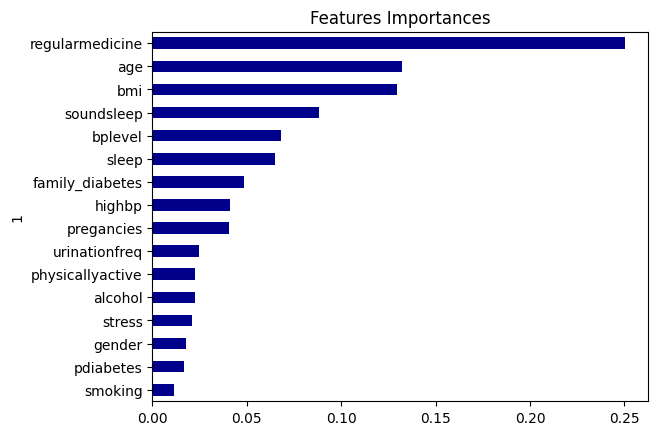

In [46]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='darkblue', title= 'Features Importances', legend=False)

## Decision Tree Model

In [47]:
# Creating the decision tree classifier instance
model = DecisionTreeClassifier()

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [48]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [49]:
# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,117,2
Diabetes Present,8,54


-------------------------------------------
Accuracy Score : 0.9447513812154696
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.94      0.98      0.96       119
Diabetes Present       0.96      0.87      0.92        62

        accuracy                           0.94       181
       macro avg       0.95      0.93      0.94       181
    weighted avg       0.95      0.94      0.94       181



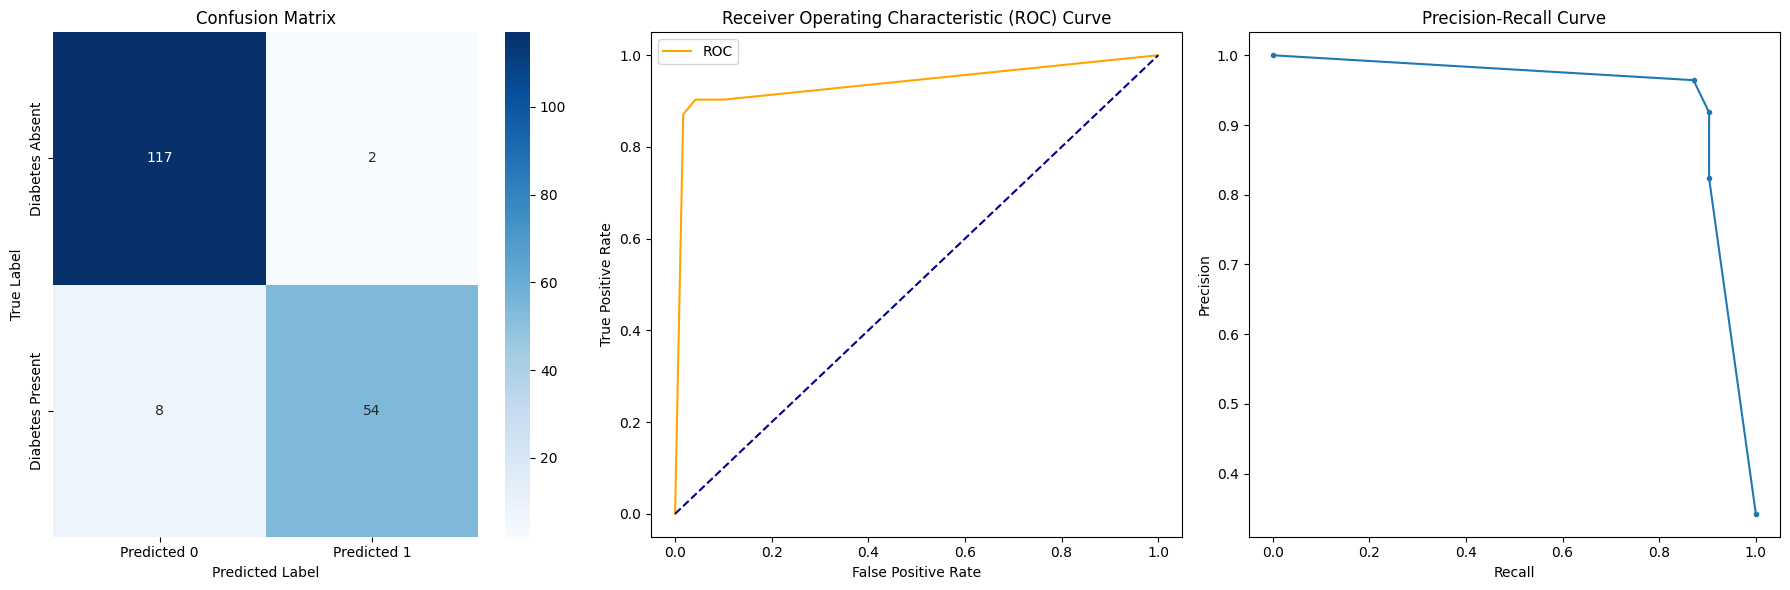

In [50]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


# Support Vector Machine (SVM) Model

In [51]:
# Creating the SVC classifier instance
model = SVC(kernel='linear')

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [52]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [53]:
# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,105,14
Diabetes Present,19,43


-------------------------------------------
Accuracy Score : 0.8176795580110497
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.85      0.88      0.86       119
Diabetes Present       0.75      0.69      0.72        62

        accuracy                           0.82       181
       macro avg       0.80      0.79      0.79       181
    weighted avg       0.82      0.82      0.82       181



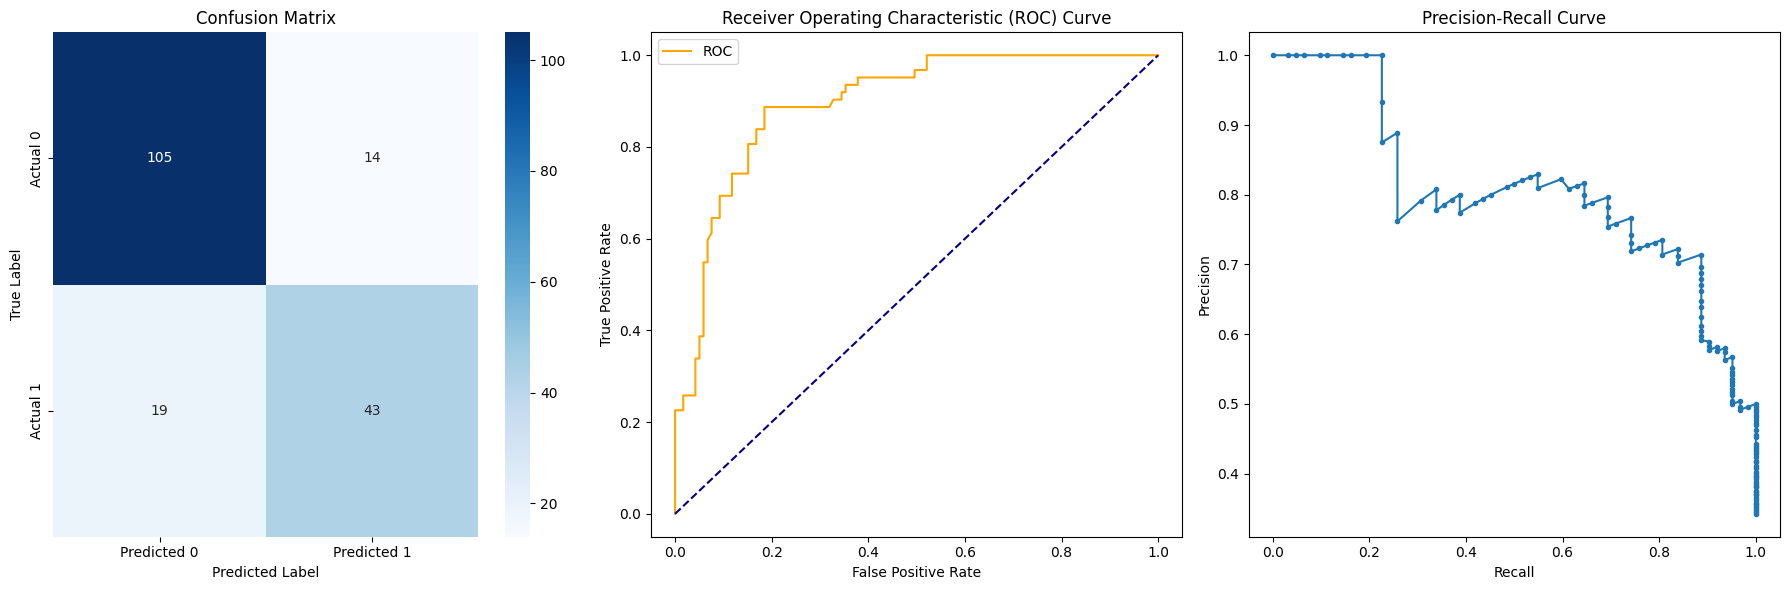

In [54]:
# Calculating probabilities for ROC curve and precision-recall curve
probs = model.decision_function(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


## K-Nearest Neighbors (KNN) Model

In [55]:
# Creating the decision tree classifier instance
model = KNeighborsClassifier(n_neighbors=3)

# Fitting the model
model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [56]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [57]:
# Displaying results
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {acc_score}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["Diabetes Absent", "Diabetes Present"]))

Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,117,2
Diabetes Present,12,50


-------------------------------------------
Accuracy Score : 0.9226519337016574
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.91      0.98      0.94       119
Diabetes Present       0.96      0.81      0.88        62

        accuracy                           0.92       181
       macro avg       0.93      0.89      0.91       181
    weighted avg       0.93      0.92      0.92       181



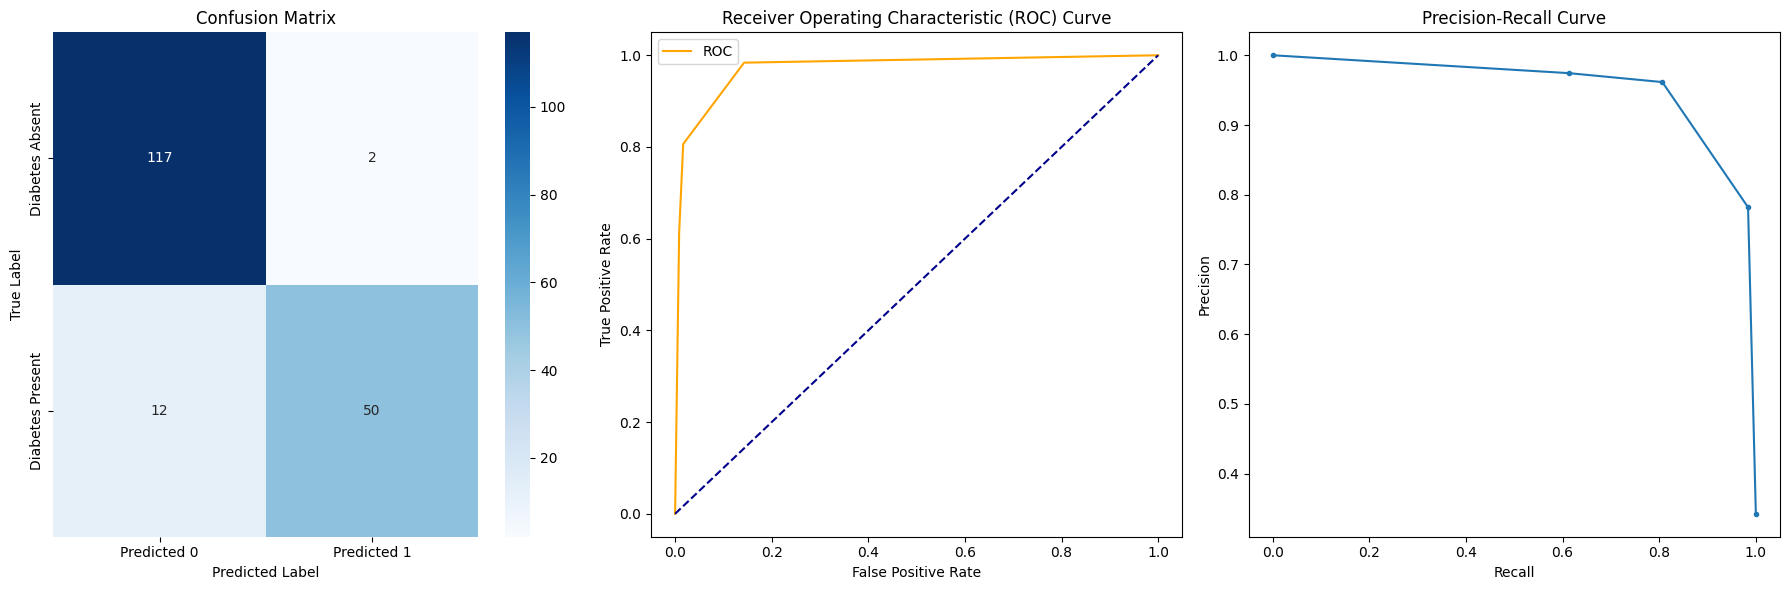

In [58]:
# Calculating probabilities for ROC curve and precision-recall curve
probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Plot confusion matrix, ROC curve, and precision-recall curve
plt.figure(figsize=(18, 6))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
plt.subplot(1, 3, 3)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


## GRIDSearchCV

In [59]:
# Define classifiers
classifiers = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Increase max_iter
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}


In [60]:
# Define hyperparameter grids for each classifier
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
}


In [61]:
# Perform Grid Search Cross Validation for each classifier
results = {}
for name, classifier in classifiers.items():
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)

    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    results[name] = {'best_params': best_params, 'best_accuracy': best_accuracy}

In [62]:


# Print results
for name, result in results.items():
    print(f"{name}:")
    print("Best Parameters:", result['best_params'])
    print("Best Accuracy:", result['best_accuracy'])
    print()

SVM:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.9210536398467433

Logistic Regression:
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Accuracy: 0.8684291187739464

Decision Tree:
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.9376532567049807

Random Forest:
Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy: 0.944588122605364

K-Nearest Neighbors:
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
Best Accuracy: 0.9515421455938696



# Neural Network Model

In [63]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define input shape based on the shape of X_train
input_shape = X_train_scaled.shape[1]

In [64]:
# Define a function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('input_units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))  # Adjust dropout rate
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        activation_choice = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation=activation_choice))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))  # Adjust dropout rate
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [72]:
# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='accuracy',
                     max_epochs=25,
                     factor=3,
                     directory='keras_tuner_logs',
                     project_name='diabetes_prediction')

# Search for the best hyperparameters without validation data
tuner.search(X_train_scaled, y_train, epochs=30, verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model on the training data
history = model.fit(X_train_scaled, y_train, epochs=30, verbose=1)


Reloading Tuner from keras_tuner_logs/diabetes_prediction/tuner0.json
Epoch 1/30
23/23 [==============================] - 4s 10ms/step - loss: 0.4102 - accuracy: 0.7978
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 0.2717 - accuracy: 0.8864
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.2365 - accuracy: 0.8961
Epoch 4/30
23/23 [==============================] - 0s 9ms/step - loss: 0.2204 - accuracy: 0.9114
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.2049 - accuracy: 0.9114
Epoch 6/30
23/23 [==============================] - 0s 10ms/step - loss: 0.1917 - accuracy: 0.9169
Epoch 7/30
23/23 [==============================] - 0s 13ms/step - loss: 0.1851 - accuracy: 0.9238
Epoch 8/30
23/23 [==============================] - 0s 10ms/step - loss: 0.1740 - accuracy: 0.9377
Epoch 9/30
23/23 [==============================] - 0s 10ms/step - loss: 0.1716 - accuracy: 0.9266
Epoch 10/30
23/23 [=====================

In [73]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model_weights.h5")


6/6 [==============================] - 0s 8ms/step - loss: 0.2095 - accuracy: 0.9558
Test Loss: 0.20947954058647156
Test Accuracy: 0.9558011293411255


In [74]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

6/6 - 0s - loss: 0.2095 - accuracy: 0.9558 - 114ms/epoch - 19ms/step
Test Loss: 0.20947954058647156, Test Accuracy: 0.9558011293411255


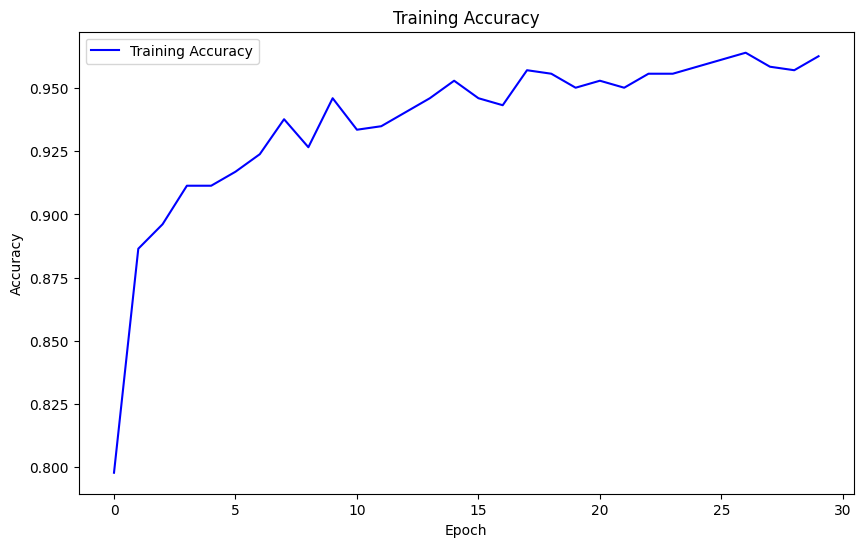

In [75]:
# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


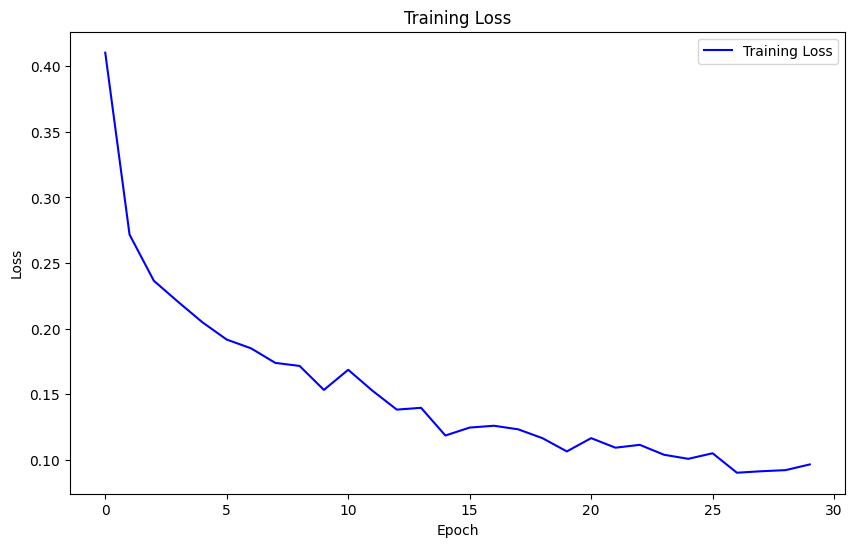

In [76]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [77]:
# Assuming y_pred contains the raw predictions and y_true contains the true labels
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
y_true = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Diabetes Absent", "Diabetes Present"], columns=["Predicted 0", "Predicted 1"]
)

# Compute and print accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Confusion Matrix:")
display(cm_df)
print("-------------------------------------------")
print(f"Accuracy Score : {accuracy}")
print("-------------------------------------------")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Diabetes Absent", "Diabetes Present"]))


6/6 [==============================] - 0s 3ms/step
Confusion Matrix:


,Predicted 0,Predicted 1
Diabetes Absent,116,3
Diabetes Present,5,57


-------------------------------------------
Accuracy Score : 0.9558011049723757
-------------------------------------------
Classification Report:
                  precision    recall  f1-score   support

 Diabetes Absent       0.96      0.97      0.97       119
Diabetes Present       0.95      0.92      0.93        62

        accuracy                           0.96       181
       macro avg       0.95      0.95      0.95       181
    weighted avg       0.96      0.96      0.96       181



6/6 [==============================] - 0s 3ms/step


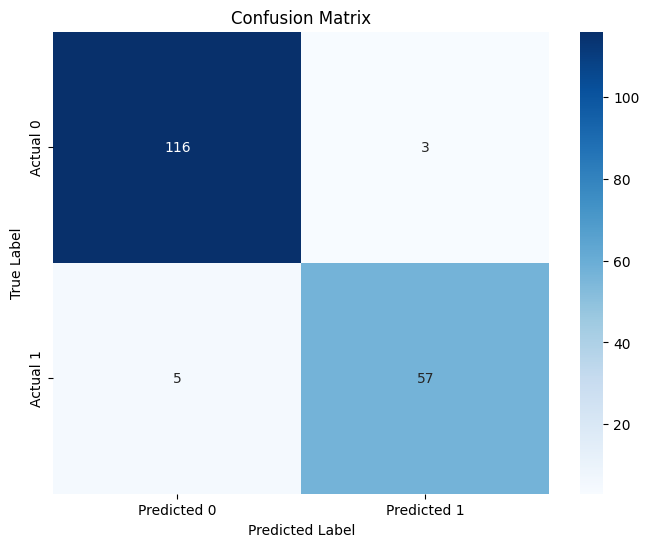

In [78]:
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")  # Apply threshold for binary classification
y_true = y_test

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Summary Report: Machine Learning Models for Diabetes Prediction

Description:
This report evaluates the performance of various machine learning models in predicting the presence or absence of diabetes using a provided dataset. The models considered include Neural Network, SVM (Support Vector Machine), Logistic Regression, Decision Tree, Random Forest, and K-Nearest Neighbors (KNN).

Neural Network:

Accuracy: 95.58%
Precision (Diabetes Absent): 96%
Precision (Diabetes Present): 95%
Recall (Diabetes Absent): 97%
Recall (Diabetes Present): 92%
F1-score (Diabetes Absent): 97%
F1-score (Diabetes Present): 93%
SVM:

Accuracy: 81.77%
Precision (Diabetes Absent): 85%
Precision (Diabetes Present): 75%
Recall (Diabetes Absent): 88%
Recall (Diabetes Present): 69%
F1-score (Diabetes Absent): 86%
F1-score (Diabetes Present): 72%
Logistic Regression:

Accuracy: 81.22%
Precision (Diabetes Absent): 85%
Precision (Diabetes Present): 74%
**Recall (Diabetes Absent
):** 87%

Recall (Diabetes Present): 69%
F1-score (Diabetes Absent): 86%
F1-score (Diabetes Present): 72%
Decision Tree:

Accuracy: 94.48%
Precision (Diabetes Absent): 94%
Precision (Diabetes Present): 96%
Recall (Diabetes Absent): 98%
Recall (Diabetes Present): 87%
F1-score (Diabetes Absent): 96%
F1-score (Diabetes Present): 92%
Random Forest:

Accuracy: 94.48%
Precision (Diabetes Absent): 94%
Precision (Diabetes Present): 96%
Recall (Diabetes Absent): 98%
Recall (Diabetes Present): 87%
F1-score (Diabetes Absent): 96%
F1-score (Diabetes Present): 92%
KNN:

Accuracy: 92.27%
Precision (Diabetes Absent): 91%
Precision (Diabetes Present): 96%
Recall (Diabetes Absent): 98%
Recall (Diabetes Present): 81%
F1-score (Diabetes Absent): 94%
F1-score (Diabetes Present): 88%
Conclusion:

The Neural Network model demonstrates the highest accuracy and balanced performance in predicting both classes.
Decision Tree and Random Forest models also show promising results, closely following the Neural Network in terms of accuracy and performance metrics.
SVM, Logistic Regression, and KNN exhibit lower accuracy and performance metrics compared to the other models.
Based on the results, the Neural Network model is recommended for accurate and reliable diabetes prediction.